In [3]:
#files needed to run the processing. NB utils is a package that Dane helped me make. It includes some important functions in it. 
import utils

import skimage
import numpy as np
import matplotlib.pyplot as plt
import PIL
from PIL import Image, ImageDraw

#non-local means
from skimage import data, img_as_float, img_as_ubyte, exposure
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.metrics import peak_signal_noise_ratio
from skimage.util import random_noise

#registration
from skimage.registration import phase_cross_correlation
from skimage.registration._phase_cross_correlation import _upsampled_dft

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import os
import tifffile as tif

import ipywidgets as widgets


###  Dry scan needed for registration

In [4]:
#do we need to flow in the full dry scan every time? 
#can we apply the same transform once we know what the reference is 
# Read the TIFF images for the dry scan 
dirname = 'E:\\New reconstructions\\merged\\merged\\05_dry_bin2_merged'
slices  = 50 #change this is you want to load in more slices NB python starts from 0 

dry_data = []

for i, fname in enumerate(os.listdir(dirname)):
    im = Image.open(os.path.join(dirname, fname))
    imarray = np.array(im)
    dry_data.append(imarray)
    if i >= slices:
        break

# convert to a 3D array and normalise so data is between 0 and 1 
dry_data  = np.asarray(dry_data) 
dry_data = utils.preprocess(dry_data)


### Load in flow scan and wet scan (both needed)

In [ ]:
slices  = 1799 #change this is you want to load in more slices NB python starts from 0. Currently registering on a smaller number of slices. 

In [5]:
dirname =  'E:\\New reconstructions\\merged\\merged\\07_wet_bin2_merged'
wet_data = []

for i, fname in enumerate(os.listdir(dirname)):
    im = Image.open(os.path.join(dirname, fname))
    imarray = np.array(im)
    wet_data.append(imarray)
    if i >= slices:
        break

wet_data = np.asarray(wet_data)
wet_data = utils.preprocess(wet_data)


In [26]:

# Read the TIFF images
flow_dirname = 'E:\\New reconstructions\\merged\\merged\\09_h2lh_merged'
flow_data = []

for i, fname in enumerate(os.listdir(flow_dirname)):
    im = Image.open(os.path.join(flow_dirname, fname))
    imarray = np.array(im)
    flow_data.append(imarray)
    if i >= slices:
        break

# convert to a 3D array and normalise so data is between 0 and 1 
flow_data  = np.asarray(flow_data) 
flow_data = utils.preprocess(flow_data)


### Crop to a cylinder 

In [7]:
#NB this code can be edited to change the location and centre of the cylinder for the cropping 

def crop(img):
    z, h, w = img.shape
    
    # creating cylindrical mask
    lum_img = Image.new('L', [h, w], 0)
    draw = ImageDraw.Draw(lum_img)
    draw.pieslice([(135, 90), (h-75, w-75)], 0, 360, fill=255)  #change values here to change the mask shape 
    mask = np.array(lum_img)
    mask = np.repeat(mask[np.newaxis, :, :], z, axis=0)
    mask = (mask == 0)

    assert img.shape == mask.shape
    assert mask.dtype == np.bool8

    foreground = img.copy()
    foreground[mask] = 255

    return foreground

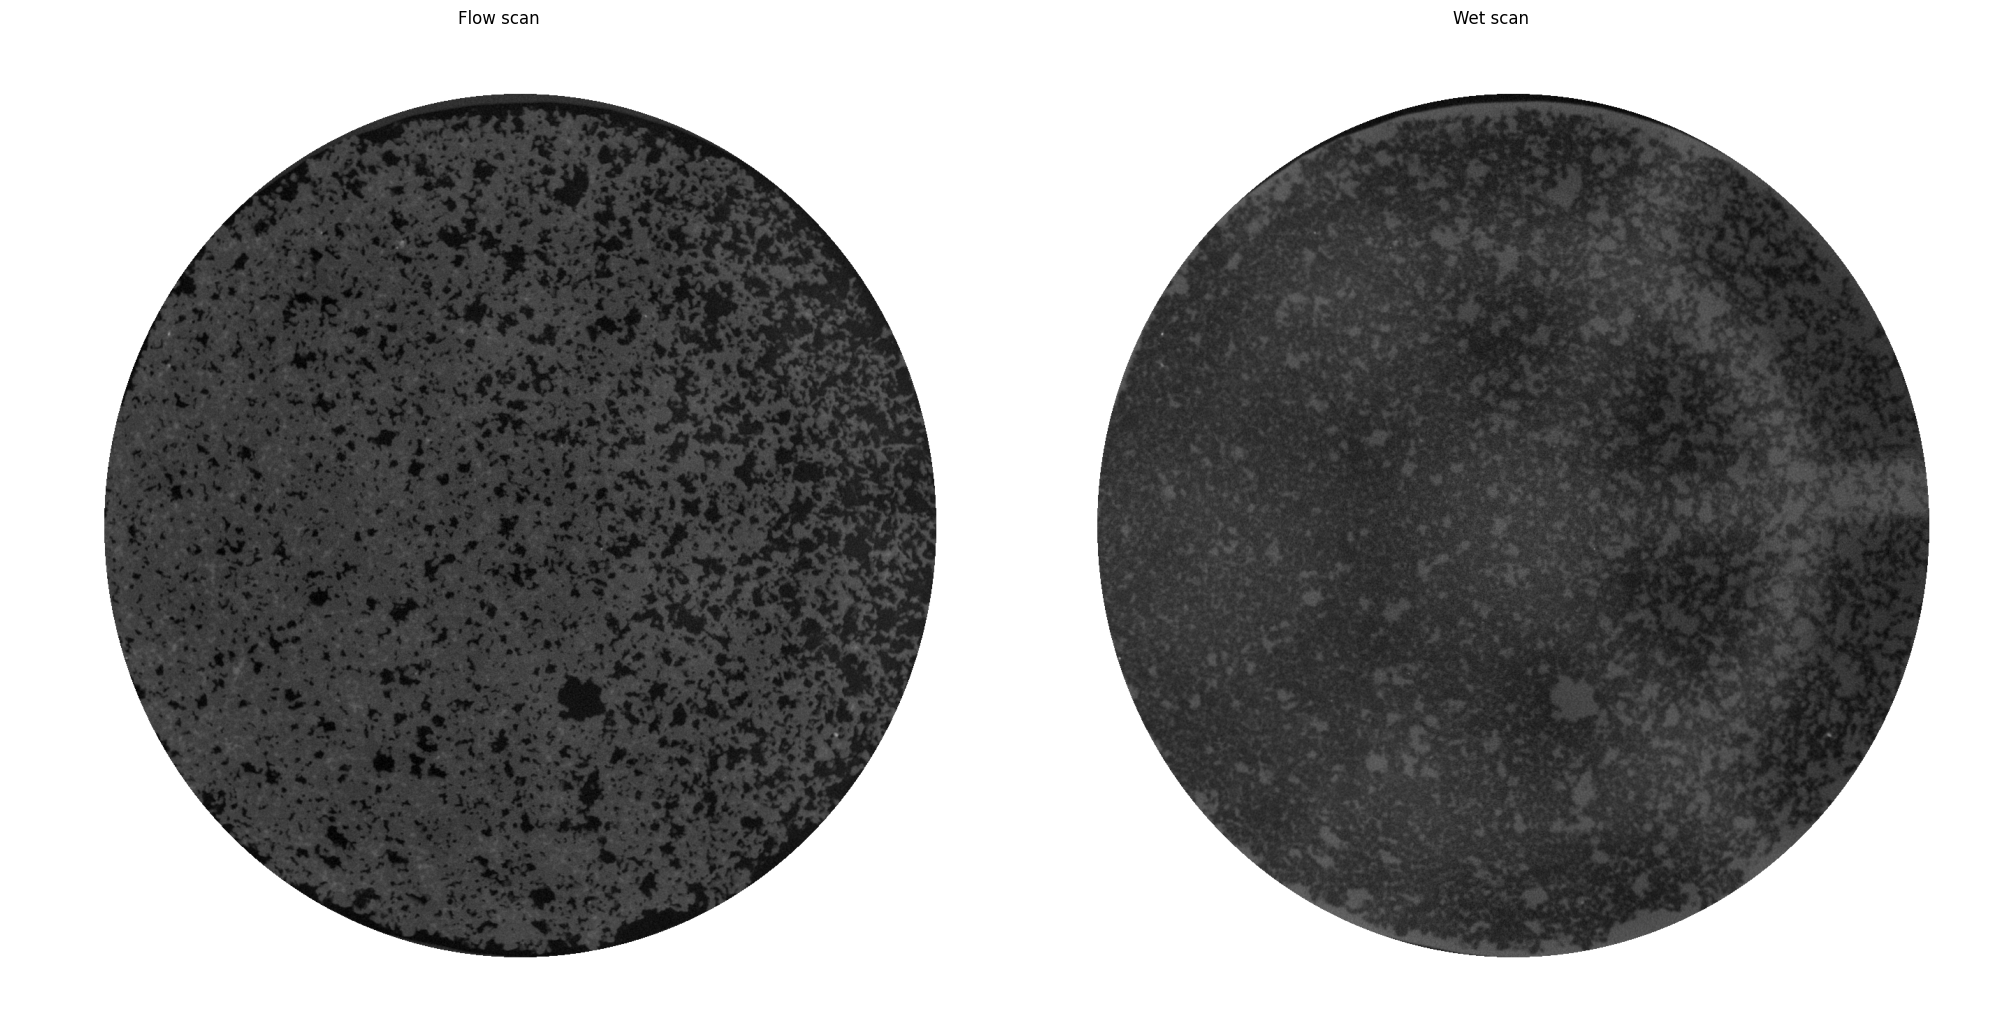

In [8]:
# The images are cropped into a cylinder (so that we aren't including the outer sleeve in the analysis) 
flow_data = crop(flow_data)
wet_data  = crop(wet_data)
dry_data  = crop(dry_data)

#NB lots of data overwriting at this point to preserve memory 

#Check the data 
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 20),
                       sharex=True, sharey=True)

ax[0].imshow(flow_data[1, :, :],cmap='gray')
ax[0].axis('off')
ax[0].set_title('Flow scan')


ax[1].imshow(wet_data[1,:, :],cmap='gray')
ax[1].axis('off')
ax[1].set_title('Wet scan')

fig.tight_layout()
plt.show()

### Registration 

In [9]:
#filter the images prior to registration

#non-local means filter works better on float of image with no exposure or histogram modification.
dry_float  = dry_data.astype(np.float64)
flow_float = flow_data.astype(np.float64)
wet_float  = wet_data.astype(np.float64)
del dry_data
del wet_data
del flow_data

def nlm_denoise(Img,patch,dist):
    
    def nlm_denoise_wrap(array):
        correct=img_as_float(array[0])
        sigma_est = np.mean(estimate_sigma(correct))
        correct = denoise_nl_means(correct, h=3 * sigma_est, sigma=sigma_est,fast_mode=True,patch_size=patch, patch_distance=dist)
        return correct[np.newaxis, ...]
    
    denoise=skimage.util.apply_parallel(nlm_denoise_wrap,Img, chunks=(1, Img.shape[1],Img.shape[2]), dtype='float',compute=True)
    
    return  denoise

denoise_dry = nlm_denoise(dry_float, patch = 3,  dist = 6)
del dry_float

denoise_flow = nlm_denoise(flow_float, patch = 3,  dist = 6)
del flow_float

denoise_wet = nlm_denoise(wet_float, patch = 3,  dist = 6)
del wet_float






In [10]:
denoise_dry  = utils.preprocess(denoise_dry.astype(np.uint8))
denoise_flow = utils.preprocess(denoise_flow.astype(np.uint8))
denoise_wet  = utils.preprocess(denoise_wet.astype(np.uint8))


Shift in Z direction for flow scan -2.0
Shift in Z direction for wet scan 1.0


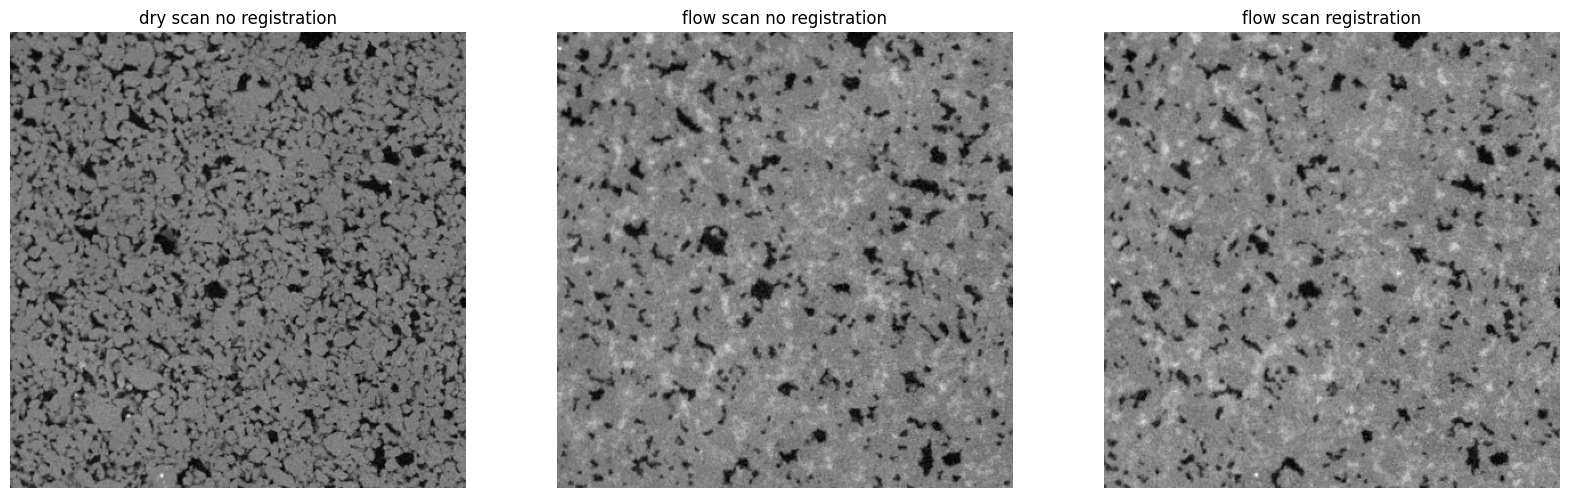

In [11]:

# pixel precision 
shift, error, diffphase = phase_cross_correlation(denoise_dry[1:50,:, :], denoise_flow[1:50,:, :])
print('Shift in Z direction for flow scan', shift[0])


shift_wet, error_wet, diffphase_wet = phase_cross_correlation(denoise_dry[5:15,:, :], denoise_wet[5:15,:, :])
print('Shift in Z direction for wet scan', shift_wet[0])

#Check the data 
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 20),
                       sharex=True, sharey=True)

ax[0].imshow(denoise_dry[5,400:800, 400:800],cmap='gray')
ax[0].axis('off')
ax[0].set_title('dry scan no registration')


ax[1].imshow(denoise_flow[5,400:800, 400:800],cmap='gray')
ax[1].axis('off')
ax[1].set_title('flow scan no registration')

ax[2].imshow(denoise_flow[5 -int(shift[0]) ,400:800, 400:800],cmap='gray')
ax[2].axis('off')
ax[2].set_title('flow scan registration')
plt.show()

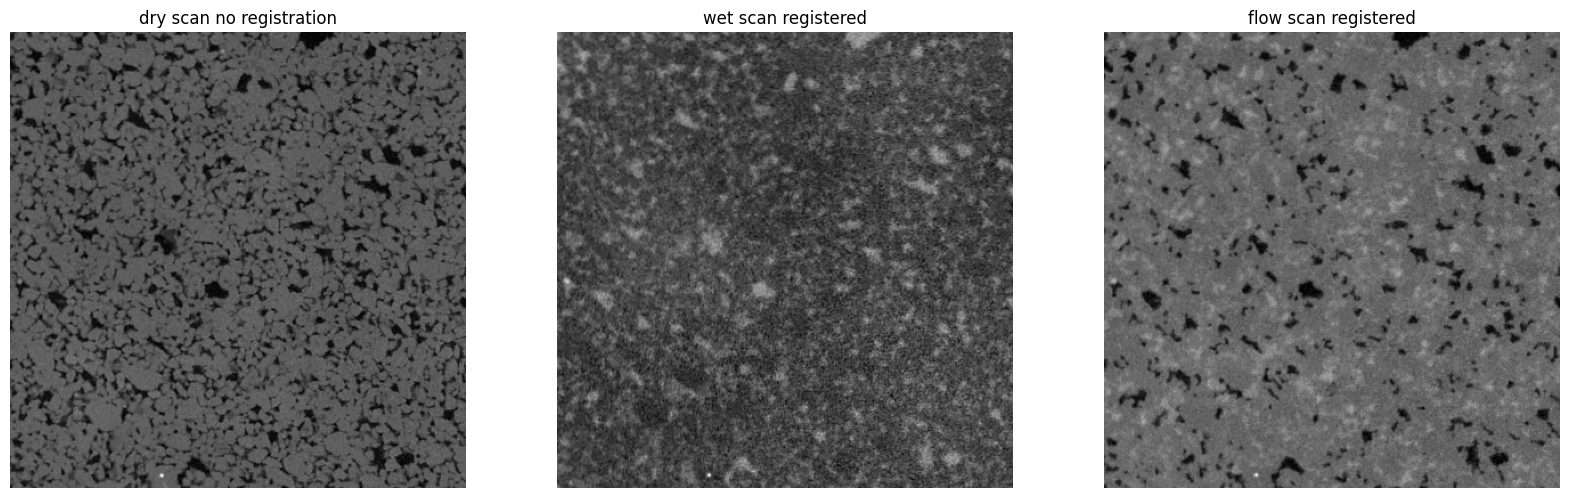

In [12]:
#Check the data 
fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(20, 20),
                       sharex=True, sharey=True)

ax[0].imshow(denoise_dry[6,400:800, 400:800],cmap='gray')
ax[0].axis('off')
ax[0].set_title('dry scan no registration')


ax[1].imshow(denoise_wet[8 ,400:800, 400:800],cmap='gray')
ax[1].axis('off')
ax[1].set_title('wet scan registered')

ax[2].imshow(denoise_flow[6 -int(shift[0]) ,400:800, 400:800],cmap='gray')
ax[2].axis('off')
ax[2].set_title('flow scan registered')
plt.show()



### Register the wet and flow scans to the dry scan 

In [13]:
denoise_wet_reg  = denoise_wet[(10 - int(shift[0])):, :, :] 
denoise_flow_reg = denoise_flow[(10 - int(shift[0])):, :, :] 


### Subtraction of flow scan with wet scan to perform gas segmentation with no masking from the dry scan

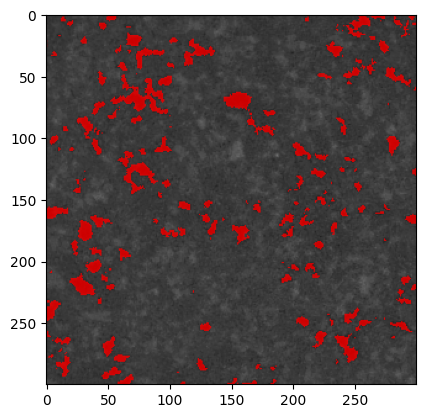

In [14]:
just_gas = denoise_flow_reg - denoise_wet_reg

def simple_thresholding(img: np.array, min_threshold: float, max_threshold: float) -> np.array:
    bins=255
    # find where histogram goes to 0 for the brine 
    hist_values = img[:, :, :].ravel()
    hist_bincount = np.bincount(hist_values)
    end_brine     = np.argmax(hist_bincount<2000)

    threshold_img = ((img.max() - img.min()) * min_threshold + img.min() <= img) & (img <= (img.max() - img.min()) * max_threshold + img.min())
    threshold_img = np.array(threshold_img, dtype=np.bool8)

    assert len(threshold_img.shape) == 3  # rgb
    return threshold_img


gas_v1         = simple_thresholding(just_gas, min_threshold=0.5, max_threshold = 0.89) 
filtered_gasv1 = skimage.morphology.remove_small_objects(gas_v1, min_size=4)    
filtered_gasv1 = skimage.morphology.remove_small_holes(filtered_gasv1, area_threshold=4)    


seg_gas = utils.sanity_check(denoise_flow_reg.astype(np.uint8)[3, ...], filtered_gasv1[3, ...], 0.8)
plt.imshow(seg_gas[500:800, 500:800])
plt.show()

### Check the segmentation was successful 

In [15]:

z_widget = widgets.IntSlider(
    value=2,
    min=0,
    max=10,
    step=1,
)


overlay_widget = widgets.RadioButtons(
    options=[True, False],
    description='Overlay:',
    disabled=False,
)


def view_slice(img: np.ndarray, z: int, overlay: bool, mask: bool) -> None:
    depth, h, w = img.shape
    assert isinstance(img, np.ndarray)
    assert isinstance(z, int)
    assert isinstance(overlay, bool)
    assert 0 <= z < depth

    slice = img[z, :, :]

    if overlay:
        slice = utils.preprocess(slice)
        mask  = mask[z, :, :]
        slice = utils.sanity_check(slice, mask)
    fig = plt.figure(figsize=(20, 12))
    plt.imshow(slice, cmap='gray')
    plt.show()


widgets.interact(view_slice, img=widgets.fixed(denoise_flow_reg[:, 500:1500,500:1500]), z=z_widget, overlay=overlay_widget, mask = widgets.fixed(filtered_gasv1[:, 500:1500,500:1500]))

interactive(children=(IntSlider(value=2, description='z', max=10), RadioButtons(description='Overlay:', option…

<function __main__.view_slice(img: numpy.ndarray, z: int, overlay: bool, mask: bool) -> None>

### Mask the segmented image with the dry scan 

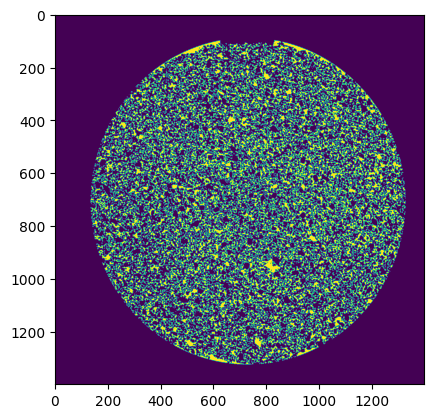

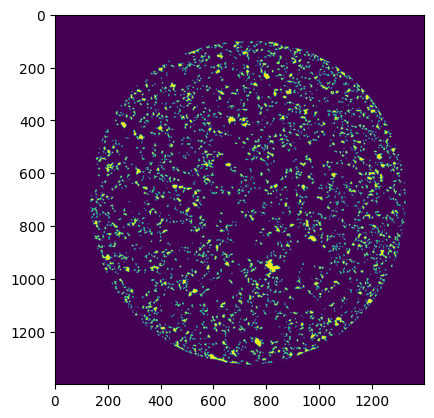

In [27]:
#load in the segmented dry image 

segmented_dry = skimage.io.imread('merged_binning_2_38_1927.tif')
segmented_sub = skimage.io.imread('merged_sub_resolved_binning_2_38_1927.tif')

segmented_dry = segmented_dry[10:slices+int(shift[0])+1, :, :]

plt.imshow(segmented_dry[3, :, :])
plt.show()

plt.imshow(filtered_gasv1[3, :, :])
plt.show()



In [17]:

def mask_with_dry(img, dry_scan):
    if img.max() > 1:
        img = (img - img.min()) / (img.max() - img.min()) * 255
        img = img.astype(np.uint8)

    # creating mask from segmented dry scan
    mask = (dry_scan == 0)

    assert img.shape == mask.shape
    assert mask.dtype == np.bool8
    # mask image 
    foreground = img.copy()
    foreground[mask] = 255 

    # create a composite image using the alpha layer
    masked_img = np.array(foreground, dtype=np.uint8)
    return masked_img 


### Use the mask to get the location of the water 

In [28]:
segmented_wet = mask_with_dry(filtered_gasv1 == 1, segmented_dry)
masked_gas    = mask_with_dry(filtered_gasv1 == 0, segmented_dry)


segmented_flow = segmented_wet + (masked_gas * 2)



### Saving the segmented flow image

In [29]:
tif.imsave('segmented_flow_{}.tif'.format(flow_dirname.split('\\')[-1]), segmented_flow, bigtiff=True)

C:\Users\cspurin\AppData\Local\Temp\ipykernel_19352\1670175725.py:1: DeprecationWarning: <tifffile.imsave> is deprecated. Use tifffile.imwrite
  tif.imsave('segmented_flow_{}.tif'.format(flow_dirname.split('\\')[-1]), segmented_flow, bigtiff=True)


### Extra code looking at segmentation done after masking with the dry scan. Currently using other method

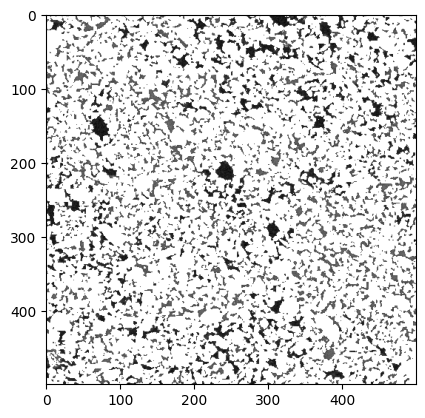

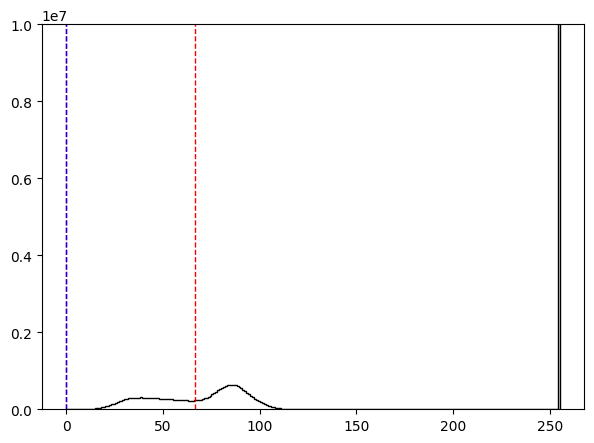

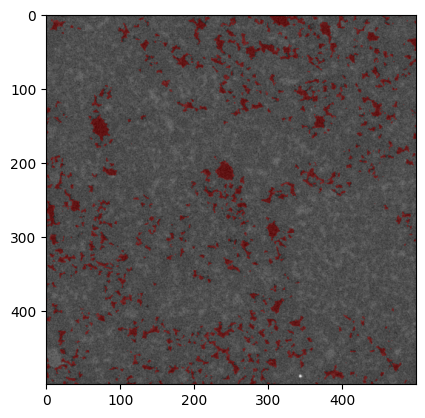

In [ ]:
#currently incorrect, with segmented scan not looking like the flow data 
#apply the transformation to the dry scan 
segmented_reg = segmented_dry[:slices-1, ...] #current crude registration 
flow_reg      = flow_data[(0-int(shift[0])):(-0 +int(shift[0])), ...]
wet_reg       = wet_data[(0-int(shift[0])):(-0 +int(shift[0])), ...]


masked_flow =  mask_with_dry(flow_reg, segmented_reg)
masked_wet  =  mask_with_dry(wet_reg, segmented_reg)
masked_just_gas = masked_flow  - masked_wet

fig = figsize =(20, 20)
plt.imshow(masked_flow[3,500:1000, 500:1000], cmap= "gray")
plt.show()

'''#quick test of histograms 
bins=255
fig, ax = plt.subplots(figsize =(7, 5))
ax.hist(masked_flow.ravel()*2, bins=bins, histtype='step', color='red')
ax.hist((masked_wet.ravel()) *2, bins=bins, histtype='step', color='blue')
ax.set_ylim(0, 7e5)
plt.show()'''

gas_v2         = simple_thresholding(masked_flow, min_threshold=0, max_threshold = 0.26) # previously 0.15 and 0.45 
filtered_gasv2 = skimage.morphology.remove_small_objects(gas_v2, min_size=4)    
filtered_gasv2 = skimage.morphology.remove_small_holes(filtered_gasv2, area_threshold=4)    

seg_gasv2 = utils.sanity_check(flow_reg[3, ...], filtered_gasv2[3, ...], 0.3)
plt.imshow(seg_gasv2[500:1000, 500:1000])
plt.show()

### Comparison of methods

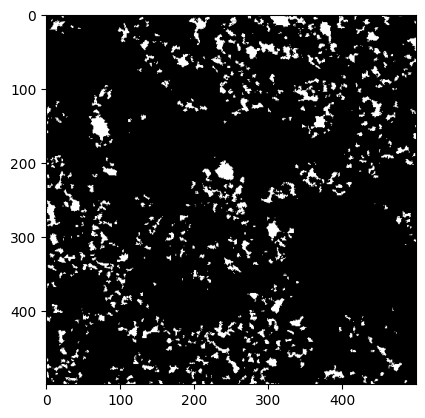

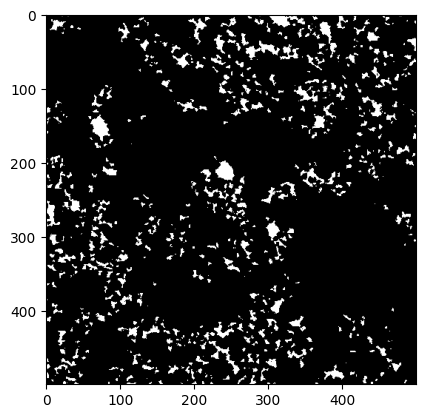

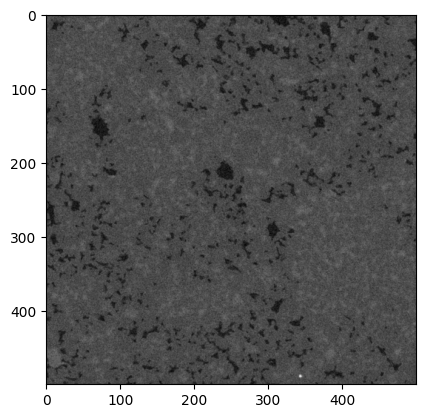

The percentage differnce in gas saturation is -5.5 %


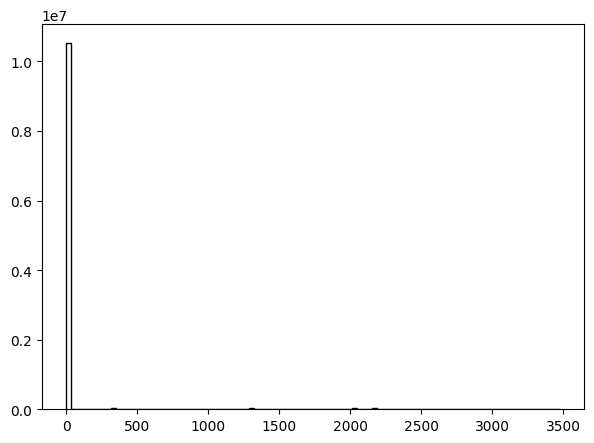

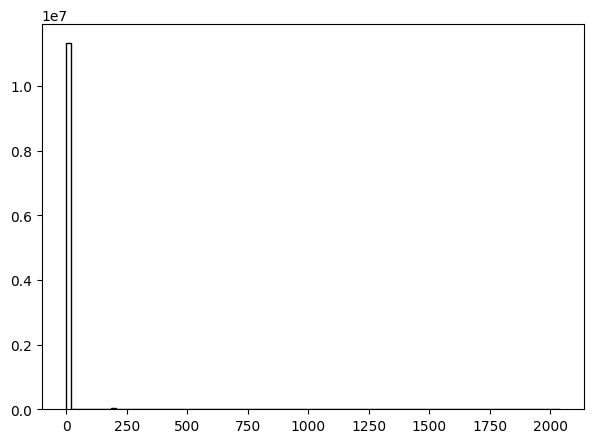

The percentage differnce in gas connectivity is -52.0 %


In [ ]:
filtered_gasv1_comp = filtered_gasv1[1:-1, ...]

fig = figsize =(20, 20)
plt.imshow(filtered_gasv1_comp[3,500:1000, 500:1000], cmap= "gray")
plt.show()
fig = figsize =(20, 20)
plt.imshow(filtered_gasv2[3,500:1000, 500:1000], cmap= "gray")
plt.show()

fig = figsize =(20, 20)
plt.imshow(flow_reg[3,500:1000, 500:1000], cmap= "gray")
plt.show()


#change in gas saturation for the different techniques 
x = 100* (np.count_nonzero(filtered_gasv1_comp==1) - np.count_nonzero(filtered_gasv2==1)) / (0.5* (np.count_nonzero(filtered_gasv1_comp==1) + np.count_nonzero(filtered_gasv2==1)))
print('The percentage differnce in gas saturation is', '%.1f' % x, '%')


#change in connectivity for the different techniques 

all_labelsv1 = skimage.measure.label(filtered_gasv1_comp, background = 0)
all_labelsv2 = skimage.measure.label(filtered_gasv2, background = 0)

labels_v1 = all_labelsv1[np.nonzero(all_labelsv1)]
labels_v2 = all_labelsv2[np.nonzero(all_labelsv2)]


bins_wide = 100
fig, ax = plt.subplots(figsize =(7, 5))
ax.hist(labels_v1.ravel(), bins=bins_wide, histtype='step', color='black')
plt.show()

fig, ax = plt.subplots(figsize =(7, 5))
ax.hist(labels_v2.ravel(), bins=bins_wide, histtype='step', color='black')
plt.show()

y = 100* (all_labelsv2.max() - all_labelsv1.max()) / (0.5* (all_labelsv1.max() + all_labelsv2.max()))
print('The percentage differnce in gas connectivity is', '%.1f' % y, '%')





In [ ]:
#How much connectivity and gas saturation is lost in masking the flow segmentation 
input =(filtered_gasv1_comp == 0)
masked_gasv1  =  mask_with_dry(input, segmented_reg)



#change in gas saturation from masking 
x2 = 100* (np.count_nonzero(filtered_gasv1_comp==1) - np.count_nonzero(masked_gasv1==0)) / (0.5* (np.count_nonzero(filtered_gasv1_comp==1) + np.count_nonzero(masked_gasv1==0)))
print('The percentage differnce in gas saturation is', '%.1f' % x2, '%')


#change in connectivity from masking 
all_labelsv3 = skimage.measure.label(masked_gasv1, background = 1)

labels_v3 = all_labelsv3[np.nonzero(all_labelsv3)]

y = 100* (all_labelsv3.max() - all_labelsv1.max()) / (0.5* (all_labelsv1.max() + all_labelsv3.max()))
print('The percentage differnce in gas connectivity is', '%.1f' % y, '%')


The percentage differnce in gas saturation is 16.1 %
The percentage differnce in gas connectivity is -14.7 %


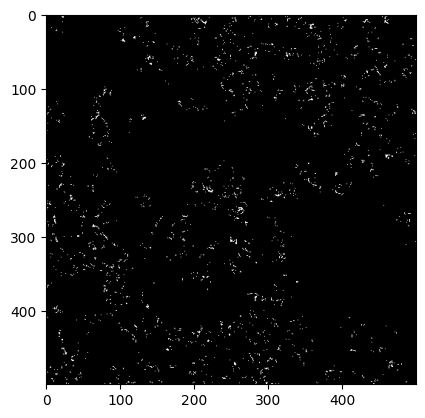

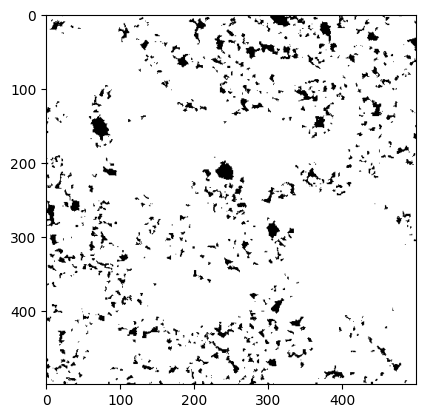

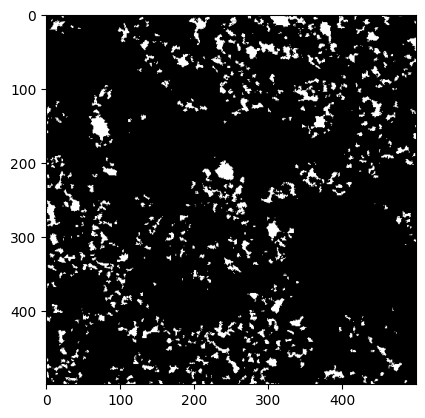

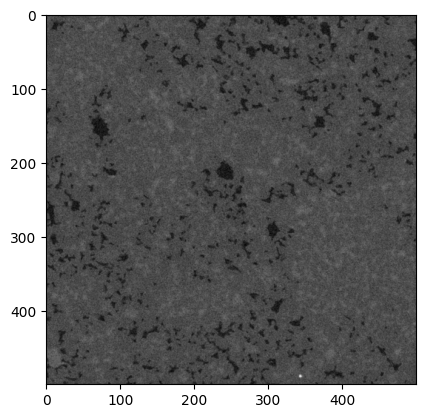

In [ ]:
fig = figsize =(20, 20)
plt.imshow(filtered_gasv1_comp[3,500:1000, 500:1000]+ masked_gasv1[3,500:1000, 500:1000], cmap= "gray")
plt.show()

fig = figsize =(20, 20)
plt.imshow(masked_gasv1[3,500:1000, 500:1000], cmap= "gray")
plt.show()

fig = figsize =(20, 20)
plt.imshow(filtered_gasv1_comp[3,500:1000, 500:1000], cmap= "gray")
plt.show()


fig = figsize =(20, 20)
plt.imshow(flow_reg[3,500:1000, 500:1000], cmap= "gray")
plt.show()